In [ ]:
from torchaudio.datasets import LIBRISPEECH

raw_dataset = LIBRISPEECH(root= "", download = True)

100%|██████████| 5.95G/5.95G [05:33<00:00, 19.1MB/s]
100%|██████████| 331M/331M [00:15<00:00, 22.2MB/s]


In [ ]:
speaker_map = {}
new_id = 0
num_lines_to_skip = 12

with open("/content/LibriSpeech/SPEAKERS.TXT", "r") as f:
    # Skip the header line
    for _ in range(num_lines_to_skip):
        next(f)
    for line in f:
        reader_id, gender, subset, *_ = line.strip().split("|")
        if subset.strip() == "train-clean-100":
            speaker_map[int(reader_id)] = new_id
            new_id += 1
        if new_id >= 10:  # Stop after mapping 100 speakers
            break

print(f"Speaker mapping created: {speaker_map}")

Speaker mapping created: {19: 0, 26: 1, 27: 2, 32: 3, 39: 4, 40: 5, 60: 6, 78: 7, 83: 8, 87: 9}


Using device cuda
There are 1167 samples in the dataset.
torch.Size([1, 128, 157]) tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


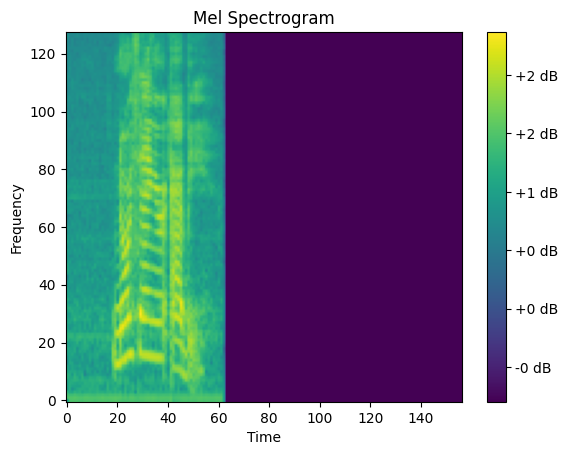

In [ ]:
import os

import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torch.nn.functional as F
import matplotlib.pyplot as plt


class LibriSpeechWrapper(Dataset):
    def __init__(self, dataset, transformation, target_sample_rate, num_samples, device, speaker_map):
        self.dataset = dataset
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.speaker_map = speaker_map

        # Filter the dataset to only include samples from the selected speakers
        self.filtered_indices = [i for i, (_, _, _, label, _, _) in enumerate(self.dataset)
                                 if int(label) in self.speaker_map]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, index):
        index = self.filtered_indices[index]
        signal, sr, _, label, _, _ = self.dataset.__getitem__(index)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = signal.to(self.device)
        signal = self.transformation(signal)
        signal = torchaudio.transforms.AmplitudeToDB()(signal)
        new_speaker_id = self.speaker_map.get(int(label), -1)  # Handle non-existent IDs
        if new_speaker_id == -1:
            raise ValueError(f"Speaker ID {label} not found in mapping")
        signal = self._normalize_global(signal)
        return signal, F.one_hot(torch.tensor(new_speaker_id), 10).to(torch.float32)

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            midpoint = signal.shape[1] // 2
            start = midpoint - (self.num_samples // 2)
            end = start + self.num_samples
            if start < 0:
                start = 0
                end = self.num_samples
            elif end > signal.shape[1]:
                end = signal.shape[1]
                start = end - self.num_samples
            signal = signal[:, start:end]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _normalize_global(self, signal):
        mean = signal.mean()
        std = signal.std()
        signal = (signal - mean) / std
        return signal

    def get_unique_labels(self):
        """Counts and returns the number of unique labels in the dataset."""
        unique_labels = set()
        for _, label in self:
            unique_labels.add(label)
        return len(unique_labels)

# Constants
SAMPLE_RATE = 16000
NUM_SAMPLES = 16000 * 5

# Determine device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

# Define the mel spectrogram transformation
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

# Create the dataset
dataset = LibriSpeechWrapper(raw_dataset,
                             mel_spectrogram,
                             SAMPLE_RATE,
                             NUM_SAMPLES,
                             device,
                             speaker_map)

print(f"There are {len(dataset)} samples in the dataset.")
signal, label = dataset[0]
print(signal.shape, label)

plt.imshow(signal[0, :, :].cpu(), aspect='auto', origin='lower')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
import torch
from torch import nn
from torchsummary import summary

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNetVoiceClassifier(nn.Module):
    def __init__(self, block, layers, num_classes=251):
        super(ResNetVoiceClassifier, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

def resnet18(num_classes):
    return ResNetVoiceClassifier(BasicBlock, [2, 2, 2, 2], num_classes)

# Instantiate the model
model = resnet18(num_classes=10).to(device)

# Print the summary of the model
summary(model, (1, 128, 157))  # Adjust the input size according to your Mel spectrogram dimensions


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 79]             784
       BatchNorm2d-2           [-1, 16, 64, 79]              32
              ReLU-3           [-1, 16, 64, 79]               0
         MaxPool2d-4           [-1, 16, 32, 40]               0
            Conv2d-5           [-1, 16, 32, 40]           2,304
       BatchNorm2d-6           [-1, 16, 32, 40]              32
              ReLU-7           [-1, 16, 32, 40]               0
            Conv2d-8           [-1, 16, 32, 40]           2,304
       BatchNorm2d-9           [-1, 16, 32, 40]              32
             ReLU-10           [-1, 16, 32, 40]               0
       BasicBlock-11           [-1, 16, 32, 40]               0
           Conv2d-12           [-1, 16, 32, 40]           2,304
      BatchNorm2d-13           [-1, 16, 32, 40]              32
             ReLU-14           [-1, 16,

In [ ]:
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.0001
SAMPLE_RATE = 16000
NUM_SAMPLES = 16000 * 5
TEST_SPLIT = 0.2
BETAS = (0.9, 0.999)

def create_data_loader(dataset, batch_size):
    train_size = int((1 - TEST_SPLIT) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device, epoch, epoch_losses):
    model.train()
    total_loss = 0.0
    batches = 0
    with tqdm(
                total=len(data_loader),
                desc=f"Epoch {epoch + 1}"
            ) as epoch_pbar:

      for input, target in data_loader:
          input, target = input.to(device), target.to(device)

          # calculate loss
          prediction = model(input)

          loss = loss_fn(prediction, target)
          loss.backward()
          optimiser.step()
          optimiser.zero_grad()
          epoch_pbar.update(1)
          total_loss += loss.item()
          batches += 1
          epoch_pbar.set_postfix(
                        train_loss=total_loss / batches
                    )
    epoch_losses.append(total_loss / batches)


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    epoch_losses = []
    for i in range(epochs):
        train_single_epoch(model, data_loader, loss_fn, optimiser, device, i, epoch_losses)
    print("Finished training")
    return epoch_losses


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")

# Assuming `model` and `dataset` are defined elsewhere in your code
model = model.to(device)
train_dataloader, test_dataloader = create_data_loader(dataset, BATCH_SIZE)

# Initialise loss function + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=BETAS)
# Train model
epoch_losses = train(model, train_dataloader, loss_fn, optimiser, device, EPOCHS)

# Save model
torch.save(model.state_dict(), "voice_classification.pth")
print("Trained feed forward net saved at voice_classification.pth")

Using cuda


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/59 [00:00<?, ?it/s]

Finished training
Trained feed forward net saved at voice_classification.pth


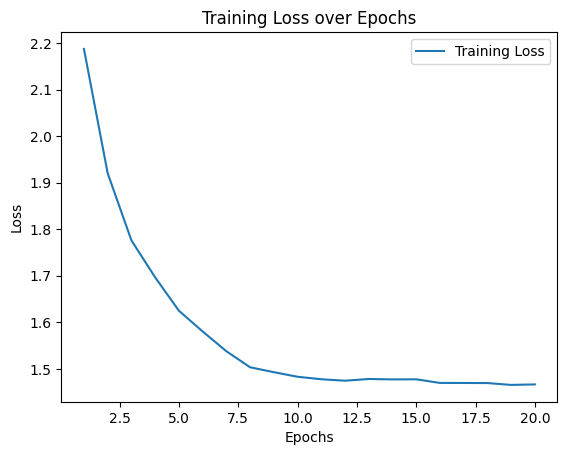

In [ ]:
plt.figure()
plt.plot(range(1, EPOCHS + 1), epoch_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

def predict(model, input, target):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
    return predicted_index, target

def evaluate(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.argmax(dim=1).cpu().numpy())
    accuracy = accuracy_score(all_targets, all_predictions)
    return accuracy

In [ ]:
import torch
import torchaudio

if __name__ == "__main__":
    # load back the model
    cnn = resnet18(num_classes=10).to(device)
    state_dict = torch.load("voice_classification.pth")
    cnn.load_state_dict(state_dict)

    # get a sample from the urban sound dataset for inference
    input, target = dataset[999][0], dataset[999][1] # [batch size, num_channels, fr, time]
    input.unsqueeze_(0)

    # make an inference
    predicted, expected = predict(cnn, input.to(device), target.to(device))
    print(f"Predicted: '{predicted}', expected: '{torch.argmax(expected)}'")

Predicted: '8', expected: '8'


In [ ]:
accuracy = evaluate(cnn, test_dataloader, device)
print(f"Accuracy on the test set: {accuracy}")

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy on the test set: 0.9914529914529915
